In [4]:
# Import libraries
import numpy as np
import os , csv
from os import listdir
import matplotlib.pyplot as plt
import pandas as pd
from scipy.sparse import csr_matrix
from scipy.interpolate import interp1d
from sklearn.decomposition import TruncatedSVD
%matplotlib inline
import matplotlib.pyplot as plt
import DataPreProcessing_XW



In [5]:
# Load desired data from 1 session 1 animal
# Note that there are 340 trials in 1 session
# (For more info https://github.com/nsteinme/steinmetz-et-al-2019/wiki/data-files)

data_path = '/Users/xinweichia/Documents/connected_lizards/Steinmetz_dataset/Richards_2017-10-31'

trials_intervals = np.load(data_path+'/'+'trials.intervals.npy') # in seconds
spike_times = np.load(data_path+'/'+'spikes.times.npy') * 1000 # Unbinned spike times in ms
trials_gocue_times = np.load(data_path+'/'+'trials.goCue_times.npy') 
trials_response_choice = np.load(data_path+'/'+'trials.response_choice.npy') # -1 left, 1, right, 0 no response
spontaneous_intervals = np.load(data_path+'/'+'spontaneous.intervals.npy')
trials_response_time = np.load(data_path+'/'+'trials.response_times.npy')
spike_clusters = np.load(data_path+'/'+'spikes.clusters.npy')
site_positions = np.load(data_path+'/'+'channels.sitePositions.npy')
clusters_depths = np.load(data_path+'/'+'clusters.depths.npy')
clusters_annotation = np.load(data_path+'/'+'clusters._phy_annotation.npy')
channel_sites = np.load(data_path+'/'+'channels.site.npy')
channels_brainlocation = pd.read_csv(data_path+'/'+'channels.brainLocation.tsv', sep='\t')
clusters_probes = np.load(data_path+'/'+'clusters.probes.npy')
channels_probe = np.load(data_path+'/'+'channels.probe.npy')
trials_visual_time = np.load(data_path+'/'+'trials.visualStim_times.npy')

visual_times = trials_visual_time
# Behaviour data

wheel_movement = np.load(data_path+'/'+'wheelMoves.type.npy')
wheel_intervals = np.load(data_path+'/'+'wheelMoves.intervals.npy')


In [7]:
# Taken from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_loader.py
# To obtain brain regions
def get_good_cells(fdirpath): #
    # location in brain of each neuron
    brain_loc = os.path.join(fdirpath, "channels.brainLocation.tsv")

    good_cells = (np.load(os.path.join(fdirpath, "clusters._phy_annotation.npy")) >= 2 ).flatten()
    clust_channel = np.load(os.path.join(fdirpath, "clusters.peakChannel.npy")).astype(int) - 1
    br = []
    with open(brain_loc, 'r') as tsv:
        tsvin = csv.reader(tsv, delimiter="\t")
        k=0
        for row in tsvin:
            if k>0:
                br.append(row[-1])
            k+=1
    br = np.array(br)
    good_cells = np.logical_and(good_cells, clust_channel.flatten()<len(br))
    brain_region = br[clust_channel[:,0]]


    return good_cells, brain_region, br

good_cells, brain_regions ,br = get_good_cells(data_path) # Get brain regions

# Bin cells according to input bin size

def bin_spikes(spike_times, bin_size = 10):
    
    # Using clusters._phy_annotation.npy obtain valid clusters (i.e. >= 2)
    valid_clusters_idx = np.array(np.where(clusters_annotation>=2))[0]

    spike_time_cells = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object
    for i,cell_idx in enumerate(valid_clusters_idx):
      # Create a spike time arrays, where each array in the array is a spike time of a cell
      spike_time_cells[i] = spike_times[(np.where(spike_clusters == cell_idx)[0])]

    # Bin spike times into 10ms intervals
    spike_time_binned = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object
    sum_spikes = np.empty(len(valid_clusters_idx), dtype=object) # Initalise empty object

    for cell_num in np.arange(len(spike_time_cells)): 
        spike_time_hist = np.histogram(spike_time_cells[cell_num],bins = np.arange(0,np.floor(spike_time_cells[cell_num][-1]),bin_size))
        spike_time_binned[cell_num] = spike_time_hist[0]
        sum_spikes[cell_num] = np.sum(spike_time_binned[cell_num])

    cell_spikes_max = np.argmax(sum_spikes) # cell with the maximum number of spikes for plotting purposes
    
    # Spike_time_binned returns binned spikes sorted into cells
    # Spike_time_cells returns UNbinned spikes sorted into cells
    # cell_spikes_max returns a single cell index that has the max number of spikes (i.e most active cell)
    return spike_time_binned, spike_time_cells, cell_spikes_max

spike_time_binned, spike_time_cells, cell_spikes_max = bin_spikes(spike_times,10)


# (Need to change the sorting into matrices rather than vectors)

def sort_cells_trials(spike_time_binned, epoch_duration = 400 , bin_size = 10):

    # Epoch duration is defined as the period after the visual stimulus

    # Sort into trials
    spike_time_binned_trial = np.empty(len(spike_time_cells), dtype=object)
    spike_time_binned_trial_response = np.empty(len(spike_time_cells), dtype=object)
    for cell_num in np.arange(len(spike_time_cells)):
        spike_time_binned_trial[cell_num] = np.empty(len(trials_intervals), dtype=object)
        spike_time_binned_trial_response[cell_num] = np.empty(len(trials_intervals), dtype=object)
  
        for i,trials_start_end in enumerate(trials_intervals):
            # Sort spikes into their trial numbers. 
            spike_time_binned_trial[cell_num][i] = spike_time_binned[cell_num][ int(np.floor(trials_start_end[0]*(1000/bin_size))) : int(np.floor(trials_start_end[1]*(1000/bin_size)))]
            # Using visual onset to splice a trial into visual onset : visual onset +400ms
            spike_time_binned_trial_response[cell_num][i] = spike_time_binned[cell_num][(int(np.floor(trials_visual_time[i]*(1000/bin_size)))) : (int(np.floor(trials_visual_time[i]*(1000/bin_size)) + epoch_duration))]
            
    # spike_time_binned_trial returns spikes that are sorted into cells and trials
    # spike_time_binned_trial_response returns spikes that are sorted into cells and trials, and spliced accordingly to desired epoch duration post-visual stim onset
    
    return spike_time_binned_trial, spike_time_binned_trial_response

# Shape of spike_time_binned_trial[cell_num][trial_num][# of bins]

#spike_time_binned_trial, spike_time_binned_trial_response = sort_cells_trials(spike_time_binned,40)
spike_time_binned_trial, spike_time_binned_trial_response = sort_cells_trials(spike_time_binned,40,10)

# Sort trials into 3 trial types based on argument (e.g. response_choice, feedback type), left, 

def sort_cells_trial_types(spike_time_binned_trial_response):

    # Input: spike_time_binned_trial_response can be any spike_time_binned variable regardless of whether it has been spliced.

    # Get response choice trials types
    right_choice_trials = np.where(trials_response_choice == -1)[0]
    left_choice_trials = np.where(trials_response_choice == 1)[0]
    no_response_choice_trials = np.where(trials_response_choice == 0)[0]

    # Sort trials into response type
    left_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    right_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    no_response_spike_time_response = np.empty(len(spike_time_cells), dtype=object)
    
    for cell_num in np.arange(len(spike_time_cells)):
        left_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][left_choice_trials]
        right_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][right_choice_trials]
        no_response_spike_time_response[cell_num] = spike_time_binned_trial_response[cell_num][no_response_choice_trials]
    
    # Returns 3 variables by sorting the spike_time_binned variable into left, right no response trials
    return left_spike_time_response, right_spike_time_response, no_response_spike_time_response

left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response)

# Shape of spike time response left_spike_time_response[cell_num][trial_num][# of bins in 400ms]
# (Maybe i should change it to left_spike_time_response[cell_num][trial_num x # of bins] ?)

def sort_cells_brain_regions(spike_time_response, *input_region):
    
    regional_spike_time_response = np.empty(len(input_region), dtype=object)
    for i,region in enumerate(input_region):
        # Get brain regions that correponds to the desired region
        brain_region_annotation = clusters_annotation[brain_regions == region]
        # Select only valid regions i.e. annotation >=2
        valid_brain_regions_idx = np.where(brain_region_annotation >= 2)[0]
        # Index the spike time to get spikes from desired regions
        regional_spike_time_response[i] = spike_time_response[valid_brain_regions_idx]
    
    # Merge spikes across all regions
    merged_region_spikes = []
    for i in np.arange(len(regional_spike_time_response)):
        merged_region_spikes = np.append(merged_region_spikes, regional_spike_time_response[i])
    
    # Return spike time sorted into regions and merged across all regions
    # Indexing: regional_spike_times[cell_num][trial_num][# of bins]
    return merged_region_spikes

mid_brain_circuits=['SCs','SCm','MRN','APN','PAG','ZI']
frontal_circuits=['MOs','PL','ILA','ORB','MOp','SSp']

regional_left_spike = sort_cells_brain_regions(left_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_right_spike = sort_cells_brain_regions(right_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_no_response_spike = sort_cells_brain_regions(no_response_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')

# Concatenate trial epochs into an entire time series 
# e.g. if 400ms/trial were used(260trial x 40bins will be reshaped into 1 x 10400bins

def concat_trials_2_timeseries(spike_time_response):
    concat_spike_time_response = np.empty(len(spike_time_response), dtype=object)
    
    for cell_num in np.arange(len(spike_time_response)):
        concat_spike_time_response[cell_num] = np.array([])
        for trial_num in np.arange(len(spike_time_response[cell_num])):
            concat_spike_time_response[cell_num] = np.append(concat_spike_time_response[cell_num],(spike_time_response[cell_num][trial_num]))
    
    # Return concatenated spike time response 
    # Indexing: spike_times[cell_num][# of bins ]
    return concat_spike_time_response

concat_left_spike_times = concat_trials_2_timeseries(regional_left_spike)
concat_right_spike_times = concat_trials_2_timeseries(regional_right_spike)
concat_no_resonse_spike_times = concat_trials_2_timeseries(regional_no_response_spike)

print(concat_left_spike_times[3])
print(regional_left_spike[1].shape)

# Geting behavioural data
# Taken from https://github.com/MouseLand/steinmetz2019_NMA/blob/master/steinmetz_loader.py

def get_wheel(fdirpath):
    wheel = np.load(os.path.join(fdirpath, "wheel.position.npy")).flatten()
    wheel_times = np.load(os.path.join(fdirpath,   "wheel.timestamps.npy"))
    return wheel, wheel_times

# Get wheel peristimulus time histogram. Aligned to the onset of visual stim.
# (I'm assuming that the wheel trials here have T0 = Onset of visual stim. Hence it should be the aligned to our spike_times)
def wpsth(wheel, wheel_times, etime, dT, dt):
    ntrials = len(etime)
    NT = int(dT/dt)
    f = interp1d(wheel_times[:,1], wheel_times[:,0], fill_value='extrapolate')
    S  = np.zeros((ntrials, NT))
    for j in range(ntrials):
        # Note that etime = visual_time onset - 0.5s
        tsamp = f(np.arange(etime[j], etime[j]+dT+1e-5, dt)).astype('int32')
        S[j,:] = wheel[tsamp[1:]] - wheel[tsamp[:-1]]
    return S

dt = 1/100
dT = 2.5
T0 = .5

wheel, wheel_times = get_wheel(data_path)
wheel_position = wpsth(wheel, wheel_times,visual_times-T0, dT, dt)
# plt.plot(wheel_position[10])

# Concatenate behaviour based on epoch we set to get same dimension as neural activity for comparison
# (i.e. reshape matrix (260trials x 40bins) to form vector (1 x 10400bins)

# left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response)
# Note that we have 3 trials types to sort for behaviour data too

def concat_behaviour_2_timeseries(wheel_position, epoch_duration = 400 ,bin_size = 10):
    # Get response choice trials types
    right_choice_trials = np.where(trials_response_choice == -1)[0]
    left_choice_trials = np.where(trials_response_choice == 1)[0]
    no_response_choice_trials = np.where(trials_response_choice == 0)[0]
    
    left_concat_wheel_position = np.array([])
    right_concat_wheel_position = np.array([])
    no_response_concat_wheel_position = np.array([])
    for trial_num in left_choice_trials:
        left_concat_wheel_position = np.append(left_concat_wheel_position,wheel_position[trial_num,0:int(epoch_duration/bin_size)])
    for trial_num in right_choice_trials:
        right_concat_wheel_position = np.append(right_concat_wheel_position,wheel_position[trial_num,0:int(epoch_duration/bin_size)])
    for trial_num in no_response_choice_trials:
        no_response_concat_wheel_position = np.append(no_response_concat_wheel_position,wheel_position[trial_num,0:int(epoch_duration/bin_size)])
        
    return left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position

left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position = concat_behaviour_2_timeseries(wheel_position, epoch_duration = 400 ,bin_size = 10)


# Check if behaviour dimension tallies with neural time series
if concat_right_spike_times[3].shape[0] == right_concat_wheel_position.shape[0]:
    print("The dimensions of behaviour and neural activity tallies " + "| Shape:" + str(right_concat_wheel_position.shape))
else:
    print("The dimensions is wrong")
    
print(left_concat_wheel_position.shape)
print(right_concat_wheel_position.shape)
print(no_response_concat_wheel_position.shape)

[0. 0. 0. ... 0. 0. 0.]
(99,)
The dimensions of behaviour and neural activity tallies | Shape:(3000,)
(3960,)
(3000,)
(3440,)


<function matplotlib.pyplot.show(*args, **kw)>

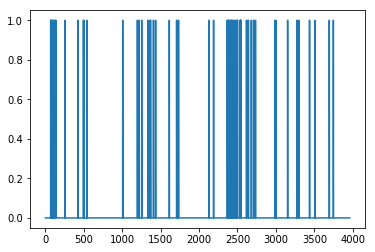

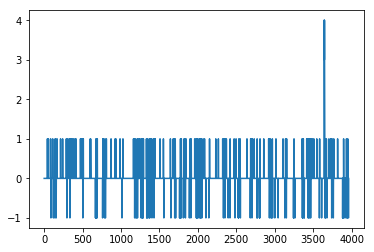

In [8]:
# Perform some quick visualisation on the spike and behaviour data

plt.figure(0)
cell_num = 42
plt.plot(concat_left_spike_times[cell_num])
plt.show

plt.figure(1)
plt.plot(left_concat_wheel_position)
plt.show



In [34]:
# Get neural activity data
good_cells, brain_regions ,br = get_good_cells(data_path) # Get brain regions
spike_time_binned, spike_time_cells, cell_spikes_max = bin_spikes(spike_times,10)
spike_time_binned_trial, spike_time_binned_trial_response = sort_cells_trials(spike_time_binned,40,10)
left_spike_time_response, right_spike_time_response, no_response_spike_time_response = sort_cells_trial_types(spike_time_binned_trial_response)

# Midbrain cells
regional_left_spike = sort_cells_brain_regions(left_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_right_spike = sort_cells_brain_regions(right_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
regional_no_response_spike = sort_cells_brain_regions(no_response_spike_time_response, 'SCs','SCm','MRN','APN','PAG','ZI')
midbrain_concat_left_spike_times = concat_trials_2_timeseries(regional_left_spike)
midbrain_concat_right_spike_times = concat_trials_2_timeseries(regional_right_spike)
midbrain_concat_no_response_spike_times = concat_trials_2_timeseries(regional_no_response_spike)

# Forebrain cells
regional_left_spike = sort_cells_brain_regions(left_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
regional_right_spike = sort_cells_brain_regions(right_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
regional_no_response_spike = sort_cells_brain_regions(no_response_spike_time_response, 'MOs','PL','ILA','ORB','MOp','SSp')
forebrain_concat_left_spike_times = concat_trials_2_timeseries(regional_left_spike)
forebrain_concat_right_spike_times = concat_trials_2_timeseries(regional_right_spike)
forebrain_concat_no_response_spike_times = concat_trials_2_timeseries(regional_no_response_spike)

# Get behaviour data
wheel, wheel_times = get_wheel(data_path)
wheel_position = wpsth(wheel, wheel_times,visual_times-T0, dT, dt)
left_concat_wheel_position, right_concat_wheel_position, no_response_concat_wheel_position = concat_behaviour_2_timeseries(wheel_position, epoch_duration = 400 ,bin_size = 10)

<function matplotlib.pyplot.show(*args, **kw)>

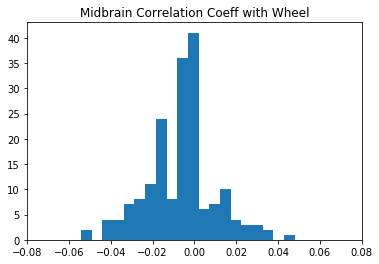

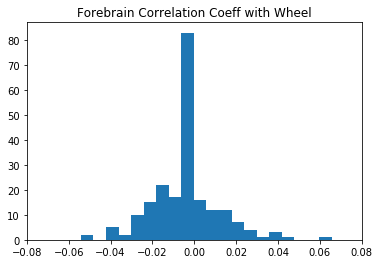

In [48]:
# Perform regression analysis

corr_coeff = np.array([])
for cell_num in np.arange(len(midbrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(midbrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(0)
plt.hist(corr_coeff,bins = 20)
plt.title('Midbrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show

corr_coeff = np.array([])
for cell_num in np.arange(len(forebrain_concat_left_spike_times)):
    corr_coeff = np.append(corr_coeff,np.corrcoef(forebrain_concat_left_spike_times[cell_num], left_concat_wheel_position)[0,1])

plt.figure(1)
plt.hist(corr_coeff,bins = 20)
plt.title('Forebrain Correlation Coeff with Wheel')
plt.xlim((-0.08, 0.08))
plt.show


In [30]:
print(corr_coeff)

(193,)
